# Bayesian Logistic Regression

## Bank Card Choice

Logistic regression is a common benchmark model in machine learning because of its simplicity (no parameter tuning in a model without regularization), robustness (not prune to overfitting) and well-understood theoretical background. It's also a common model in many fields for researchers looking to analyze data to empirically test their theories, because its coefficients are easy to interpret. Logistic regression is also a good starting point to understand how Bayesian modeling works and to check out Edward (http://edwardlib.org), a new framework build on tensorflow to make Baysian methods faster and easier to use in combination with neural networks.

I'll work through an experiment to understand the necessary steps and see if I can get the code right. The data comes from a marketing experiment/conjoint analysis where participants were shown a choice between two hypothetical bank cards. The two cards were identical in all characteristics except for two.  Each participant evaluated 13-17 paired comparisons 
involving a fraction of attributes. 

The data bank_choice contains columns:

- id: participant identifier
- choice: choice indicator (1=first card; 0=second card)
- remaining columns: x_hi1 - x_hi2, difference in attribute x between card 1 and card 2

The data bank_demo contains columns:

- id: participant identifier
- remaining columns: demographic information

Data Source:
Gelman, A., Carlin, J. B., Stern, H. S., & Rubin, D. B. (2003). Bayesian Data Analysis.

In [1]:
import numpy as np # fast standard math capabilities
import pandas as pd # easy data handling
from sklearn.model_selection import train_test_split # scikit-learn for ML
import edward as ed 
import tensorflow as tf 
import matplotlib.pyplot as plt # Useful for plotting
import seaborn as sns # Advanced plots

In [2]:
# Read in the csv data using pandas
bank_choice = pd.read_csv("/Users/hauptjoh/Downloads/bank_choice.csv")

In [3]:
# Check column names
print(bank_choice.columns)

Index(['id', 'choice', 'Med_FInt', 'Low_FInt', 'Med_VInt', 'Rewrd_2',
       'Rewrd_3', 'Rewrd_4', 'Med_Fee', 'Low_Fee', 'Bank_B', 'Out_State',
       'Med_Rebate', 'High_Rebate', 'High_CredLine', 'Long_Grace'],
      dtype='object')


As always, I split the data into a subset to train the model (70%) and a different subset (30%) to check its performance. I also separate the target variable *choice* and the model input at this point.

In [4]:
choice_train, choice_test = train_test_split(bank_choice, test_size = 0.3, random_state = 123)

In [5]:
y_train = choice_train[["choice"]].values.flatten()
X_train = choice_train.drop(["choice", "id"], axis = 1).values

y_test = choice_test[["choice"]].values.flatten()
X_test = choice_test.drop(["choice", "id"], axis = 1).values

In [6]:
print(y_train.shape)
print(X_train.shape)

(10359,)
(10359, 14)


## Standard (frequentist) Logit Model

If you search for 'logistic regression with python', there's tons of pages explaining how to estimate a logistic regression model using sklearn. For comparison, I'll get the coefficients and area-under-the-ROC-curve (AUC) from the standard logit implementation.

To be specific, I train the model $P(y_{hi}=1)=\frac{exp[(x_{hi1}-x_{hi2})^T\beta]}{1+exp[(x_{hi1}-x_{hi2})^T\beta]}$,

where $\beta$ are the coefficients to estimate and $x_{hi1}$ and $x_{hi2}$ are the characteristics of choice 1 and choice 2 for the $i$-th set of choices for person $h$.

We estimate the coefficients by maximizing the log-likelihood. An important extension to the logit model is regularization by the L1- (LASSO) or L2-norm (ridge). Intuitively, we add a new penalty term to the target function that decreases performance with increasing size of coefficients to make the model more "simple". Without Bayesian reasoning, this has some clear practical advantages, but to my knowledge no convincing theory behind it beyond "when we force the coefficients to be smaller, the model is less complex and less complex models are more general/less prone to overfit".

Is not having a theoretical reason a bad thing? I know from neural networks that many practical tricks seem to work very robustly without a general proof. But not completely understanding an approach leaves us in the dark about its details, e.g. what it means to choose the L1-, L2- or why not the L4-norm? It blew my mind to find out that there's a clear Bayesian intuition for the L2-norm.

In [7]:
# Logistic regression with scikit-learn
from sklearn import linear_model
reg = linear_model.LogisticRegression(penalty="l2", C=1)
reg.fit(X=X_train, y=y_train)
# Print out the estimated coefficients
print(reg.coef_)

[[ 1.59500819  3.10176761  2.01029561 -0.05008957 -0.47475756 -0.59287675
   1.27482891  2.43007257 -0.09189518 -1.33641466  0.8876274   1.51297273
   0.58670077  1.90118752]]


In [8]:
# ROC-AUC for logit model
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, reg.predict_proba(X_test)[:,1]))

0.7924568382159967


## Bayesian Logit model

Now let's do logistic regression using Bayesian methods implemented in *Edward*. 

To work with edward, it's useful to have an intuition about how Tensorflow works. Tensorflow creates a dataflow graph in the background. If you've worked with module *Keras* before to build neural networks, you'll notice that Edward requires a little more interaction with actual tensorflow. Most importantly, remember that tensorflow will create a session in the background where all the Tensorflow variables and operations are defined. For future reference and as a reminder to myself, here's the link to Tensorflow's help page on this: https://www.tensorflow.org/programmers_guide/graphs.

In [9]:
# If things go wrong, it's useful to reset the graph and start fresh
# without having to restart the kernel
tf.reset_default_graph()

In [10]:
# Set the random number generator seed for replicable results
ed.set_seed(42) # 

Remember that we are constructing a computational graph in the background. Without understanding any details, that means that we need to be specific about the input to the computation. The way this works is that we define a placeholder with the right dimensions into which we can input data later.

In [11]:
N = y_train.shape[0] # Number of observations
D = X_train.shape[1] # Number of variables
print(N)
print(D)

10359
14


In [12]:
# Tensorflow placeholder for matrix of float numbers with dimensions [N, D]
X = tf.placeholder(tf.float32, [N, D])

Now I'll define the model or "generative process" of the data. It's useful to start at the end of the definition. 

- $y$: The observations $y$ are sampled from a Bernoulli distribution because that distribution describes the "success" of an experiment in terms of 0 and 1. It takes one parameter, which is the probability of the intresting outcome,i.e. person picks credit card option 1. We believe that this probability is different for each set of options, so we make the probability dependent on $x$.

At this point, we could maximize the likelihood of the observed outcomes with regard to the model parameters. Maximizing the likelihood sounds complicated, but the steps are not actually difficult (in this case). *Bernoulli distribution* is just shorthand for a function that we can look up on Wikipedia, 

$f(y,p)=p^{k}(1-p)^{1-y} \quad \text{for } y \in \{0,1\}$. 

Since our observations are (assumed to be) independent, the overall likelihood is the product of the likelihood of each observation.

This is the standard approach. Why is that not the best we can do? I'll try to paraphrase Christopher Bishop's great book Pattern Recognition and Machine Learning. Our model captures one kind of uncertainty: We take what we know about the credit card options and say how probable it is that a person will choose option 1.    
The standard model ignores another kind of uncertainty: We are not sure about our estimate of the coefficients, they could be a little higher or lower. We could be more certain about our estimates if, for example, we had more data, but some uncertainty will remain.    
Typically, I would address these concerns by looking at the size and p-values of the estimated effects and so on. But in the Bayesian framework, we can include them into the model to estimate the uncertainty directly.

- $b$ & $w$: I draw the bias term and each coefficient/weight of the regression part from a Normal distribution with mean 0 and variance equal to 1. But... why? I believe that the effects are likely to lie around 0 (at least since the data is normalized) and less likely to lie far away from zero. That's my *prior* belief and a design choice. The interesting part is that with enough data, the prior beliefs matter less and less and may be completely overruled.

If you've paid attention, you'll notice that I have not said how I picked the mean and variance for the normal distributions. I could also include a prior on those or estimate them from the data. Instead, I will argue that it's okay to just pick them in this case.

In [13]:
from edward.models import Normal, Bernoulli, Empirical

In [14]:
w = Normal(loc=tf.zeros(D), scale=1.0 * tf.ones(D))
b = Normal(loc=tf.zeros([]), scale=1.0 * tf.ones([]))
y = Bernoulli(probs=1/(1+tf.exp(-(ed.dot(X, w) + b))) )

The Bernoulli class can take the log-odds (logit) as argument directly, thus avoiding the calculation of the expectation, but I feel that it's helpful to make the code look like the definition of the Bernoulli distirbution that you'll find online.

In [15]:
with tf.Session() as sess:
    print(y)

RandomVariable("Bernoulli/", shape=(10359,), dtype=int32)


### MCMC

We can still write down the function behind the model including the priors, but it is not as pretty as before:

$p(y|w,b,X) = \displaystyle\prod^n_{i=1}\left[
\left(\frac{
e^{\beta_0+\beta_1X_{i1} + \ldots + \beta_1X_{i1}}}{1+e^{\beta_0+\beta_1X_{i1} + \ldots + \beta_1X_{i1}}}\right)^{y_i}
\left(1-\frac{
e^{\beta_0+\beta_1X_{i1} + \ldots + \beta_1X_{i1}}}{1+e^{\beta_0+\beta_1X_{i1} + \ldots + \beta_1X_{i1}}}\right)^{1-y_i}\right]
\cdot
\displaystyle\prod^k_{j=1} \frac{1}{\sqrt{2\pi} \sigma_j}\cdot e^{-
 \frac{(\beta_j-\mu_j)^2}{2\sigma_j^2} }$
 
Despite looking complicated, I have just written out the definitions for the Bernoulli and Normal distributions. Dealing with complex posterior distributions like this is the difficulty of Bayesian inference and probably the reason why I didn't learn about Bayesian methods in my (under)graduate classes. But we don't have to worry about this, if we don't want to build our own fancy models.

We can use sampling algorithms to approximate the distribution we are looking for (For a good overview look here: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.13.7133&rep=rep1&type=pdf). This works even in cases where this posterior distribution is much more complicated. 
The Toyota of sampling alogrithms is the metropolis-hastings algorithm. The MH algorithm works by starting with the parameters (our $b$ and $w$s) initialized at random. It then starts moving through different values of $b$ and $w$ by picking new candidates $b^*, w^*$ and accepting them if they seem 'better'. 'Better' is defined by an acceptance rule giving the probability of acceptance as 

$\alpha = \text{min}(\frac{p(x^*) q(x|x^*)}{p(x) q(x^*|x)}, 1)$. 

Don't worry about the $min(\cdot,1)$, it just ensures that our probability to jump doesn't exceed 1.

To put that in a familiar context, image you're traveling through Germany. You have no idea were tourists normally go, so you decide to pick you next destination on the fly. Let's say your traveling for good and if you find the perfect place, you are willing to go back for another day. That's a Markov Chain, since your next destination depends only on your current position. 

Today you are in Frankfurt and searching for the next train to leave the city $q(\cdot|x)$ suggets you go to Nuremberg. To decide whether to go or stay, you check online 1) how many tourists visit Frankfurt every year $p(x)$ and 2) how many tourists visit Nuremberg every year $p(x^*)$. If relatively more tourists visit Nuremberg, that's surely the place to be, so you're more likely to go. That's the original Metropolis algorithm.

Now a more efficient backpacker strategy would be to ask a random passer-by for a suggestion instead of boarding just any train. Sounds good, but there's a danger: They could make you miss out on whole parts of the country by sending you to places where people are unlikely to send you back in the direction you came from. Let's say Germans from the south are unlikely to send you back up north to Hamburg or Berlin. In this case it's better to think twice before burning that bridge and going to Nuremberg, so you correct your acceptance probability to account for the asymmetry. You can do that by taking surprising suggetions $q(x^*|x)$ more seriously and avoiding suggestions that send you to places where people will not send you back the direction you came from $p(x|x^*)$. That's the extension from the Metropolis to the Metropolis-Hastings algorithm.

The tricky part in application of the MH algorithm is to pick a proposal distribution that gives suggestions far from the places you've already seen but also enough suggestions that fit the acceptance rule. Throwing darts might suggest too many places all over Germany that no tourist has ever visited, so you'll just stay put in Frankfurt. Passers-by are likely to suggest cities in the vicinity and get you stuck in just one state for a long time.

For the example, we'll sample new candiates from a normal distribution centered around the current state. If we pick the variance of the normal distirbution too high, we'll end up with a low acceptance rate and no movement of the markov chain. If we pick the variance too low, the chain will move in small steps and will take too long to explore. I've picked 0.2 by trying a few values and aiming for an acceptance rate close to 0.5

In [16]:
proposal_w = Normal(loc=w, scale = .02)
proposal_b = Normal(loc=b, scale = .02)

We want to take *n* samples from our model, so we need to create a place to save them. Edward has a class *Empirical* which collects samples from a random variable. It then gives us direct access to the empirical statistics of the random variables and I can sample directly from it. I need to set up space to save the random variables, so I pick the number of samples that I would like to save at 30,000. I pick 30,000 because I sounds high enough to get robust results. 

In [17]:
T = 30000 # Number of iterations
qw = Empirical(tf.Variable(tf.zeros([T,D])))
qb = Empirical(tf.Variable(tf.zeros([T,])))

I can now put it all together. I would like to do inference on variables connected through the model I specified using the MH algorithm. The necessary information is

- Use function MetropolisHastings to sample
- Save the results for w in a random variable qw, for b in a random variable qb
- During sampling, samples new proposed steps from the distributions proposal_w and proposal_b
- Evaluate the target posterior given data X_train and y_train

In [18]:
from edward.inferences import MetropolisHastings
inference = MetropolisHastings({w:qw, b:qb}, 
                               {w:proposal_w, b:proposal_b},
                               data={y:y_train, X:X_train})

/Users/hauptjoh/anaconda/envs/edward/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \
/Users/hauptjoh/anaconda/envs/edward/lib/python3.6/site-packages/edward/util/random_variables.py:53: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  not np.issubdtype(value.dtype, np.int) and \


In [19]:
# Actually run inference and print update every 500 iterations
inference.run(n_print=500)

30000/30000 [100%] ██████████████████████████████ Elapsed: 72s | Acceptance Rate: 0.413


Let's see what that gets us. Contracy to the frequentist approach, our result is a distribution for each parameter $b,w_1,\ldots,w_{14}$. What does that mean? Simply put, we are not sure what the parameters are! That sounds bad, but is actually in the nature of things. 

The philosopher David Hume made a pretty convincing argument that even if I've seen the sun rise my whole life, I can never be 100% certain that it will do so tomorrow, since logical certainties can't be deducted from observation only. I can be very, very certain, though, and we can visualize that certainty. I'll visualize each distribution by sampling from it a lot of times and plotting the samples as a histogram or density plot.

In [26]:
# For variable at position var_id, sample n times and plot
var_id = 0
# Sample from the random variable's distribution 10000 times
# Don't forget to evaluate the tensors after sampling to get numpy arrays.
estimates = qw.sample(10000).eval()[:, var_id]

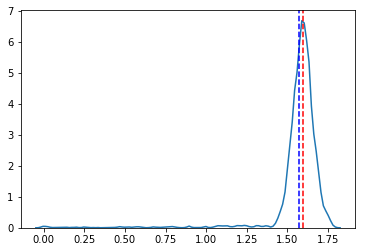

In [27]:
# Compute a density plot to have a smooth distribution of results
var_plot = sns.kdeplot(data=estimates)
# Add lines at density mean (blue) and at sklearn regression estimate (red)
plt.axvline(x=np.mean(estimates), color = "blue", linestyle="dashed")
plt.axvline(x=reg.coef_.flatten()[var_id], color = "red", linestyle="dashed")
plt.show()

How do we interpret this? I am used to seeing three things reported in studies from economics: a single estimate of the effect, a p-value and a confidence interval. How to we find a single effect estimate to report? The mean? The median? One important takeaway is that the standard approach picks a single value for us that might not be the one we would pick ourselves.

In [35]:
b_est = np.mean(qb.sample(1000).eval())
print(b_est)
print(reg.intercept_)

-0.059135817
[-0.04339837]


In [36]:
w_est = np.mean(qw.sample(1000).eval(),axis=0)
print(w_est)
print(reg.coef_)

[ 1.5769122   3.0697756   1.9952586  -0.04674401 -0.46992552 -0.588219
  1.2472618   2.3820918  -0.09895556 -1.3471849   0.8685688   1.4687728
  0.5630965   1.8716323 ]
[[ 1.59500819  3.10176761  2.01029561 -0.05008957 -0.47475756 -0.59287675
   1.27482891  2.43007257 -0.09189518 -1.33641466  0.8876274   1.51297273
   0.58670077  1.90118752]]


With point estimates from the mean of the distribution, we can follow the same math as in frequentist logistic regression to calculate probability estimates. In fact, if you're willing to do some math, you can show that this is equivalent to maximum likelihood estimation.

In [37]:
pred = tf.sigmoid(ed.dot(tf.cast(X_test, tf.float32), w_est) + b_est).eval()

In [38]:
print(pred[0:10])

[0.25302917 0.37208635 0.5394462  0.13802248 0.1548903  0.19252193
 0.6254152  0.48546207 0.69709945 0.32713148]


In [39]:
from sklearn.metrics import confusion_matrix, roc_auc_score
print(roc_auc_score(y_test, pred))

0.7922674666927396


To get true Bayesian estimates, we can avoid point estimates and instead sample from the posterior distribution of y. The resulting samples can be used to calculate better measures of our confidence in the prediction.

When predicting on the test data, an issue with Edward that I haven't figured out is that the placeholder for the input data doesn't fit anymore. We defined the placeholder to be the size of the training data for inference, but now need it to be the size of the test data. I therefore copy the posterior with the infered weights and bias distributions and a new placeholder for the test data.

In [40]:
X_post = tf.placeholder(tf.float32, X_test.shape)
y_post = Bernoulli(logits=ed.dot(X_post, qw) + qb)

Sample predictions for all observations from the Bernoulli distribution (i.e. 1/0). Repeat drawing predictions n times to approximate a prediction distribution for each observation. 

In [53]:
yhat = y_post.sample(50000, ).eval({X_post:X_test})
yhat.shape

(50000, 4440)

In [54]:
yhat[0:5,0:2]

array([[1, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 1]], dtype=int32)

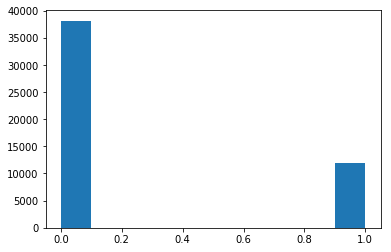

In [55]:
plt.hist(yhat[:,0])
plt.show()

In [56]:
probs = np.mean(yhat, axis = 0)

In [57]:
probs[0:10]

array([0.23756, 0.35966, 0.52944, 0.1272 , 0.1222 , 0.19194, 0.639  ,
       0.45776, 0.68214, 0.33076])

In [58]:
from sklearn.metrics import confusion_matrix, roc_auc_score
print(roc_auc_score(y_test, probs))

0.7922815666376778


The Bayesian treatment of the parameters in logistic regression naturally is not the end, but rather the beginning of my work with Bayesian models. Nevertheless, I've got some homework to do in statistics, tensorflow and edward!